In [1]:
import numpy as np
import pandas as pd
import math
import tensorflow as tf
import tensorflow.keras as tk

from keras.layers import Dense, Dropout, Flatten, Conv2D, Input, Add, \
                         Activation, ZeroPadding2D, BatchNormalization, \
                         AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model
from keras.initializers import glorot_uniform

import re
import glob
import datetime

In [2]:
physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)

2022-06-04 16:25:50.507314: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-04 16:25:50.881258: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-04 16:25:50.881473: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Primo blocco conv, NON è un residual block!\
Con input shape = (230,124,2) ==> output del layer shape = (51, 57, 32)

In [5]:
def conv1(X, filters = 32 , block="conv1", stage=2):
            
        # defining name basis
        conv_name_base = 'res' + str(stage) + block + '_branch'
        bn_name_base = 'bn' + str(stage) + block + '_branch'
        
        X_input = X
        # First component of main path
        X = Conv2D(filters, kernel_size = (6,3), strides = (2,1),
                name = conv_name_base + '2a',
                #nchannels??
                # data_format="channels_first", 
                # kernel_initializer = glorot_uniform(seed=0)
                )(X)
        X = BatchNormalization(axis = 1, name = bn_name_base + '2a')(X)
        X = Activation('relu')(X)
        
        # Second component of main path
        X = Conv2D(filters, kernel_size = (3,3), strides = (2,2),
                name = conv_name_base + '2b',
                #nchannels?? 
                # kernel_initializer = glorot_uniform(seed=0)
                )(X)
        X = BatchNormalization(axis=1, name = bn_name_base + '2b')(X)
        X = Activation('relu')(X)

        X = MaxPooling2D((3,3), strides=(1, 1))(X)
        
        return X

In [6]:
# X_input = Input(shape=(219,122,2)) 

# res1 = conv1(X_input)
# res1.summary()

Residual block Model: function that takes in input the numbers of filters and the stride of the convolutional layer.\
In this way this block can be used for all the residual blocks of the ResNet

In [7]:
def conv2x(X, stride, filters, block,stage=2):
        # defining name basis
        conv_name_base = 'res' + str(stage) + block + '_branch'
        bn_name_base = 'bn' + str(stage) + block + '_branch'

        #filters for each ==> there are two filters because 4 layer 
        #                     --> the first 2 and the last 2 have the same f 
        f1,f2 = filters
        s = stride
        #skip path for the residual part
        X_shortcut = Conv2D(f2, kernel_size = (3,3), strides = (s,s),
                name = conv_name_base + '-shortcut',
                )(X)

        X_shortcut = BatchNormalization(axis=1, name = bn_name_base + '-shortcut')(X_shortcut)

        # First component of main path
        X = Conv2D(f1, kernel_size = (1,1), strides = (1,1),
                name = conv_name_base + '2a',
                )(X)
        X = BatchNormalization(axis = 1, name = bn_name_base + '2a')(X)
        X = Activation('relu')(X)

        # Second component of main path
        X = Conv2D(f1, kernel_size = (3,3), strides = (s,s),
                name = conv_name_base + '2b',
                )(X)
        X = BatchNormalization(axis=1, name = bn_name_base + '2b')(X)
        X = Activation('relu')(X)
        
        # Second component of main path
        X = Conv2D(f2, kernel_size = (1,1), strides = (1,1),
                name = conv_name_base + '2c',
                )(X)
        X = BatchNormalization(axis=1, name = bn_name_base + '2c')(X)
        X = Activation('relu')(X)

        X = Add()([X, X_shortcut])
        out = Activation('relu')(X)

        return out


Learning rate scheduler

In [76]:
class MyLRSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, initial_learning_rate, epochs, steps_per_epoch):
    self.initial_learning_rate = initial_learning_rate
    self.epochs = epochs
    self.steps_per_epoch = steps_per_epoch
    self.m = initial_learning_rate / steps_per_epoch
    self.decay_rate = tf.constant((10**-8 / initial_learning_rate)**(((epochs - 1)*steps_per_epoch)**-1), dtype=tf.float32)
    print('decay_rate:', self.decay_rate)

  def __call__(self, step):
    result = tf.cond(tf.less(step, self.steps_per_epoch), 
                   lambda: self.m * (step+1),
                   lambda: self.initial_learning_rate * tf.keras.backend.pow(self.decay_rate, 
                                                                             tf.cast(step+1-self.steps_per_epoch, dtype=tf.float32)))

    tf.print('lr at step', step, 'is', result, output_stream='file://learning_rates.txt')
    return result  
    
  def get_config(self):
      return {
          "initial_learning_rate": self.initial_learning_rate,
          "epochs": self.epochs,
          "steps_per_epoch": self.steps_per_epoch
      }

In [77]:
# X_input = Input(shape=( 24, 26, 256)) 

# res2 = conv2x(X_input, stride=2, filters=[128,512], block="a")
# res2.summary()

Resnet

In [78]:
def ResNetJ(feature, lr_power=-3.0, epochs=15, steps_per_epoch=55):
    """
    Implementation of the popular ResNet50 the following architecture:
    Arguments:
        feature is a string which allow two input values:
        --> 'vertex' or 'energy'
    """
    
    # Define the input as a tensor with shape input_shape
    # X_input = Input(shape=(230,124,2))
    X_input = Input(shape=(230,124,2))
    
    # Stage 1
    X = conv1(X_input, block="conv1")
    # Stage2
    X = conv2x(X, stride=1, filters=[32,128], block="conv2x_1")
    X = conv2x(X, stride=1, filters=[32,128], block="conv2x_2")
    X = conv2x(X, stride=1, filters=[32,128], block="conv2x_3")

    # Stage 3
    # X = conv2x(X, stride=2, filters=[64,256], block="conv3x_1")
    X = conv2x(X, stride=1, filters=[64,256], block="conv3x_2")
    X = conv2x(X, stride=1, filters=[64,256], block="conv3x_3")
    X = conv2x(X, stride=1, filters=[64,256], block="conv3x_4")

    # Stage 4 
    # X = conv2x(X, stride=2, filters=[128,512], block="conv4x_1")
    X = conv2x(X, stride=1, filters=[128,512], block="conv4x_2")
    X = conv2x(X, stride=1, filters=[128,512], block="conv4x_3")
    X = conv2x(X, stride=1, filters=[128,512], block="conv4x_4")
    X = conv2x(X, stride=1, filters=[128,512], block="conv4x_5")
    X = conv2x(X, stride=1, filters=[128,512], block="conv4x_6")

    # Stage 5
    X = conv2x(X, stride=2, filters=[256,1024], block="conv5x_1")
    X = conv2x(X, stride=1, filters=[256,1024], block="conv5x_2")
    X = conv2x(X, stride=1, filters=[256,1024], block="conv5x_3")

    """
    prova con i filters originali del papaer ma senza i blocchi rossi
    """
    # Stage 1
    # X = conv1(X_input, block="conv1")
    # # Stage2
    # X = conv2x(X, stride=1, filters=[64,256], block="conv2x_1")
    # # X = conv2x(X, stride=1, filters=[64,256], block="conv2x_2")
    # # X = conv2x(X, stride=1, filters=[64,256], block="conv2x_3")

    # # Stage 3
    # X = conv2x(X, stride=2, filters=[64,256], block="conv3x_1")
    # X = conv2x(X, stride=1, filters=[128,512], block="conv3x_2")
    # # X = conv2x(X, stride=1, filters=[128,512], block="conv3x_3")
    # # X = conv2x(X, stride=1, filters=[128,512], block="conv3x_4")

    # # Stage 4 
    # X = conv2x(X, stride=2, filters=[128,512], block="conv4x_1")
    # X = conv2x(X, stride=1, filters=[256,1024], block="conv4x_2")
    # # X = conv2x(X, stride=1, filters=[256,1024], block="conv4x_3")
    # # X = conv2x(X, stride=1, filters=[256,1024], block="conv4x_4")
    # # X = conv2x(X, stride=1, filters=[256,1024], block="conv4x_5")
    # # X = conv2x(X, stride=1, filters=[256,1024], block="conv4x_6")

    # # Stage 5
    # X = conv2x(X, stride=2, filters=[512,2048], block="conv5x_1")
    # X = conv2x(X, stride=1, filters=[512,2048], block="conv5x_2")
    # # X = conv2x(X, stride=1, filters=[512,2048], block="conv5x_3")

    # AVGPOOL 
    X = AveragePooling2D((2,2), name='avg_pool')(X)
    # Flatten
    X = Flatten()(X)
    X = Dense(512, name='first_dense',  kernel_initializer=glorot_uniform(seed=0))(X)
    X = Dense(100, name='second_dense', kernel_initializer=glorot_uniform(seed=0))(X)

    # Output 
    if(feature=="energy"):
        X = Dense(1, name='fc_outputs', kernel_initializer=glorot_uniform(seed=0))(X)
    elif(feature=="vertex"):
        X = Dense(3, name='fc_outputs', kernel_initializer=glorot_uniform(seed=0))(X)
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name = 'ResNetJ')
    
    # Compile model
    learning_rate = 10.0**(lr_power)
    opt = tk.optimizers.Adam(learning_rate=MyLRSchedule(learning_rate, epochs, steps_per_epoch), beta_1 = 0.9, beta_2 = 0.999 )

    model.compile(loss="mse", optimizer=opt, metrics=[tf.keras.metrics.RootMeanSquaredError()])
    
    return model    

In [8]:
filename  = '../../juno_data/data/projections/proj_raw_data_train_0.npz'
labelname = '../../juno_data/data/real/train/targets/targets_train_0.csv'
x_train = np.load(filename, allow_pickle=True)['arr_0']

# nan to zero 
x_train[np.isnan(x_train)] = 0

y_train = pd.read_csv(labelname)
y_train = y_train['edep'].to_numpy()

In [80]:
BATCH_SIZE = 64
EPOCHS = 2
steps_per_epoch = math.ceil(5000 / BATCH_SIZE)
print(steps_per_epoch)
res = ResNetJ(feature="energy", epochs=EPOCHS, steps_per_epoch=steps_per_epoch)
res.summary()


79
decay_rate: tf.Tensor(0.8643883, shape=(), dtype=float32)
Model: "ResNetJ"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 230, 124, 2  0           []                               
                                )]                                                                
                                                                                                  
 res2conv1_branch2a (Conv2D)    (None, 113, 122, 32  1184        ['input_17[0][0]']               
                                )                                                                 
                                                                                                  
 bn2conv1_branch2a (BatchNormal  (None, 113, 122, 32  452        ['res2conv1_branch2a[0][0]']     
 ization)                      

Setting a learning rate which increase in the first epoch from $0$ to $10^{-3}$, and then decrease from $10^{-3}$ to $10^{-8}$


In [18]:
from keras.callbacks import LearningRateScheduler

def step_decay_schedule(initial_lr=1e-8, decay_factor=0.75, step_size=10, BS=64, ndat = 5e6):
    '''
    Wrapper function to create a LearningRateScheduler with step decay schedule.
    '''
    def schedule(epoch):
        if epoch==1:
            decay_factor = 10**(-3) * BS / ndat
            lr_sched = initial_lr * decay_factor     #(decay_factor ** np.floor(epoch/step_size))
            return lr_sched
        else:
            decay_factor = 0.1
            lr_sched = tk.optimizers.schedules.ExponentialDecay(initial_learning_rate=10**(-3) )
            return lr_sched
#        return initial_lr * (decay_factor ** np.floor(epoch/step_size))
    
    return LearningRateScheduler(schedule)

lr_sched = step_decay_schedule(initial_lr=1e-4)

# setting an adaptive learning rate

# def adapt_learning_rate(epoch):
#     if(epoch==1):
#         lr = 0.001
#     elif(epoch!=1):
#         lr = 0.1*epoch
#     return lr

# lr_history = tk.callbacks.Callback.LearningRate()
# lr_rate = tk.callbacks.LearningRateScheduler(adapt_learning_rate)


In [81]:
date_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = "logs/" + date_time
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, update_freq=100)


Fit

In [82]:

history = res.fit(ds,
         epochs=EPOCHS,
         callbacks=[tensorboard_callback],
         shuffle=True)

Epoch 1/2

reading file:
	filename: ../../juno_data/data/projections/proj_raw_data_train_304.npz 
	labelfile: ../../juno_data/data/real/train/targets/targets_train_304.csv
79/79 [==============================] - 68s 707ms/step - loss: 15.4556 - root_mean_squared_error: 3.9314
Epoch 2/2

reading file:
	filename: ../../juno_data/data/projections/proj_raw_data_train_304.npz 
	labelfile: ../../juno_data/data/real/train/targets/targets_train_304.csv
79/79 [==============================] - 64s 710ms/step - loss: 1.3401 - root_mean_squared_error: 1.1576


In [58]:
def f(n,k,s):
    n_out = (n-k)/s + 1
    return n_out
f(26,25,1)

2.0

In [32]:
def conv1(X, block="conv1", stage=2):
            
        # defining name basis
        conv_name_base = 'res' + str(stage) + block + '_branch'
        bn_name_base = 'bn' + str(stage) + block + '_branch'
        
        X_input = X
        # First component of main path
        X = Conv2D(64, kernel_size = (6,3), strides = (2,1),
                name = conv_name_base + '2a',
                #nchannels??
                # data_format="channels_first", 
                # kernel_initializer = glorot_uniform(seed=0)
                )(X)
        X = BatchNormalization(axis = 1, name = bn_name_base + '2a')(X)
        X = Activation('relu')(X)
        
        # Second component of main path
        X = Conv2D(64, kernel_size = (3,3), strides = (2,2),
                name = conv_name_base + '2b',
                #nchannels?? 
                # kernel_initializer = glorot_uniform(seed=0)
                )(X)
        X = BatchNormalization(axis=1, name = bn_name_base + '2b')(X)
        X = Activation('relu')(X)

        X = MaxPooling2D((2,2), strides=(1,1))(X)
        
        # Create model
        model = Model(inputs = X_input, outputs = X, name = 'ResNetJ')
        
        # Compile model
        learning_rate = 1e-3
        opt = tk.optimizers.Adam(learning_rate=learning_rate, beta_1 = 0.9, beta_2 = 0.999 )

        model.compile(loss="mean_squared_error", optimizer=opt, metrics=['accuracy'])
        
        return model 

In [33]:
X_input = Input(shape=(230,124,2))
res1 = conv1(X_input)
res1.summary()

Model: "ResNetJ"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 230, 124, 2)]     0         
                                                                 
 res2conv1_branch2a (Conv2D)  (None, 113, 122, 64)     2368      
                                                                 
 bn2conv1_branch2a (BatchNor  (None, 113, 122, 64)     452       
 malization)                                                     
                                                                 
 activation_230 (Activation)  (None, 113, 122, 64)     0         
                                                                 
 res2conv1_branch2b (Conv2D)  (None, 56, 60, 64)       36928     
                                                                 
 bn2conv1_branch2b (BatchNor  (None, 56, 60, 64)       224       
 malization)                                               

In [43]:
    # """
    # prova
    # """
    # # Stage 1
    # X = conv1(X_input, block="conv1")
    # # Stage2
    # X = conv2x(X, stride=1, filters=[64,256], block="conv2x_1")
    # X = conv2x(X, stride=1, filters=[64,256], block="conv2x_2")
    # X = conv2x(X, stride=1, filters=[64,256], block="conv2x_3")

    # # Stage 3
    # X = conv2x(X, stride=1, filters=[64,256], block="conv3x_1")
    # X = conv2x(X, stride=1, filters=[128,512], block="conv3x_2")
    # X = conv2x(X, stride=1, filters=[128,512], block="conv3x_3")
    # X = conv2x(X, stride=1, filters=[128,512], block="conv3x_4")

    # # Stage 4 
    # X = conv2x(X, stride=1, filters=[128,512], block="conv4x_1")
    # X = conv2x(X, stride=1, filters=[256,1024], block="conv4x_2")
    # X = conv2x(X, stride=1, filters=[256,1024], block="conv4x_3")
    # X = conv2x(X, stride=1, filters=[256,1024], block="conv4x_4")
    # X = conv2x(X, stride=1, filters=[256,1024], block="conv4x_5")
    # X = conv2x(X, stride=1, filters=[256,1024], block="conv4x_6")

    # # Stage 5
    # X = conv2x(X, stride=1, filters=[512,2048], block="conv5x_1")
    # X = conv2x(X, stride=1, filters=[512,2048], block="conv5x_2")
    # X = conv2x(X, stride=1, filters=[512,2048], block="conv5x_3")

21.0

## Check the learning rate

In [74]:
with open('learning_rates.txt') as f:
    lines = f.readlines()

In [76]:
import re
lr = np.zeros((len(lines), 2))

for i, line in enumerate(lines):
    data = re.findall("[-+]?[.]?[\d]+(?:,\d\d\d)*[\.]?\d*(?:[eE][-+]?\d+)?", line)
    lr[i, :] = data

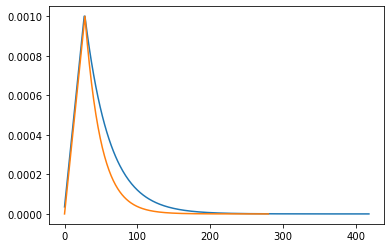

In [84]:
import matplotlib.pyplot as plt

plt.plot(lr[:419,1])
plt.plot(lr[419:, 1])

In [3]:
ntrainfiles = 100

filelist = glob.glob('../../juno_data/data/projections/*.npz')
filelist = filelist[:ntrainfiles]

In [12]:
#*******READ DATA*******#
def get_data_from_filename(filename):
   labelfile = '../../juno_data/data/real/train/targets/targets_train_{}.csv'.format(re.findall('\d+', filename.decode())[0])
   print('\nreading file:\n\tfilename:', filename.decode(), '\n\tlabelfile:', labelfile)
   labeldata = pd.read_csv(labelfile)
   labeldata = labeldata['edep'].to_numpy()
   npdata = np.load(filename, allow_pickle=True)['arr_0']
   npdata[tf.math.is_nan(npdata)] = 0
   return (npdata, labeldata)

def get_data_wrapper(filename):
   # Assuming here that both your data and label is double type
   features, labels = tf.numpy_function(
       get_data_from_filename, [filename], (tf.float64, tf.float64)) 
   return tf.data.Dataset.from_tensor_slices((features, labels))

# Create dataset of filenames.
ds = tf.data.Dataset.from_tensor_slices(filelist)
ds = ds.interleave(get_data_wrapper, num_parallel_calls=tf.data.AUTOTUNE, deterministic=False).prefetch(tf.data.AUTOTUNE).batch(64, num_parallel_calls=tf.data.AUTOTUNE, deterministic=False)

In [15]:
np.array(list(ds.take(1)))


reading file:
	filename: ../../juno_data/data/projections/proj_raw_data_train_304.npz 
	labelfile: ../../juno_data/data/real/train/targets/targets_train_304.csv


2022-06-04 16:55:59.672774: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2281600000 exceeds 10% of free system memory.



reading file:
	filename: ../../juno_data/data/projections/proj_raw_data_train_471.npz 
	labelfile: ../../juno_data/data/real/train/targets/targets_train_471.csv

reading file:
	filename: ../../juno_data/data/projections/proj_raw_data_train_498.npz 
	labelfile: ../../juno_data/data/real/train/targets/targets_train_498.csv

reading file:
	filename: ../../juno_data/data/projections/proj_raw_data_train_205.npz 
	labelfile: ../../juno_data/data/real/train/targets/targets_train_205.csv

reading file:
	filename: ../../juno_data/data/projections/proj_raw_data_train_526.npz 
	labelfile: ../../juno_data/data/real/train/targets/targets_train_526.csv

reading file:
	filename: ../../juno_data/data/projections/proj_raw_data_train_181.npz 
	labelfile: ../../juno_data/data/real/train/targets/targets_train_181.csv

reading file:
	filename: ../../juno_data/data/projections/proj_raw_data_train_763.npz 
	labelfile: ../../juno_data/data/real/train/targets/targets_train_763.csv

reading file:
	filename: ..

In [7]:
re.findall('\d+', filelist[0])[0]

'304'

In [71]:
import pickle

In [83]:
res.save_weights('models/res_weights_' + date_time + '.h5')
res.save('models/' + date_time)


INFO:tensorflow:Assets written to: models/20220603-141831/assets


In [86]:
model = tf.keras.models.load_model('models/' + date_time, custom_objects={'MyLRSchedule': MyLRSchedule})

decay_rate: tf.Tensor(0.8643883, shape=(), dtype=float32)


In [ ]:
model.predict()